# Bayesian A/B Testing: Multiple Comparisons

GitHub: [https://github.com/andrewbrdk/Bayesian-AB-Testing](https://github.com/andrewbrdk/Bayesian-AB-Testing)

*A Bayesian approach is applied to a three variant conversions A/B test. The best group is selected by posterior distributions comparison. The method is applicable to other metrics and a greater number of variants.*

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.color": "whitesmoke",
    "axes.axisbelow": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 14,
    "axes.titlepad": 20,
    "axes.titlelocation": "left",
    "lines.linewidth": 1.3,
    "legend.frameon": False,
    "figure.figsize": (10, 5),
    "figure.dpi": 200,
    "savefig.dpi": 200,
})
np.random.seed(7)

A/B tests often involve more than two variants. In these cases, statistical hypothesis testing requires adjustments for multiple comparisons [[MultipleComp](https://en.wikipedia.org/wiki/Multiple_comparisons_problem), [FWER](https://en.wikipedia.org/wiki/Family-wise_error_rate), [Bonf](https://en.wikipedia.org/wiki/Bonferroni_correction)]. In contrast, the Bayesian approach selects the best group by comparing posterior distributions, with no need for additional corrections.

Three versions of a web page — A, B, and C — each received $N=1000$ visitors. The "Continue" button was clicked by $n_{s_A}=100$, $n_{s_B}=105$, and $n_{s_C}=110$ visitors, respectively.
What is the probability that each version has the highest conversion rate?
Assume that the conversion probability is identical for each user and that all prior values are uniformly distributed.

For each variant, we seek to estimate the probability that it achieves the highest conversion rate among all groups:
$P(\text{Best } A) \equiv P(p_A > p_B \cap p_A > p_C)$ for A, with analogous expressions for B and C.
These probabilities can be estimated numerically by comparing samples drawn from the posterior distributions.
In the case of conversions, the likelihood $P(\mathcal{D} | \mathcal{H})$ follows a binomial distribution, and the prior $P(\mathcal{H})$ is a beta distribution.
Under these assumptions, the posterior distributions $P(\mathcal{H} | \mathcal{D})$ also follow beta distributions [[ConjPrior](https://en.wikipedia.org/wiki/Conjugate_prior), [BetaDist](https://en.wikipedia.org/wiki/Beta_distribution), [SciPyBeta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)].

$$
P(\mathcal{H} | \mathcal{D}) \propto P(\mathcal{D} | \mathcal{H}) P(\mathcal{H})
$$

$$
P(\mathcal{D} | \mathcal{H}) = P(n_s, N | p) = \mbox{Binom}(n_s, N | p) = C_{N}^{n_s} p^{n_s} (1-p)^{N-n_s}
$$

$$
P(\mathcal{H}) = P(p) = \mbox{Beta}(p; \alpha, \beta) = 
\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} p^{\alpha-1}(1-p)^{\beta-1}
$$

$$
\begin{split}
P(\mathcal{H} | \mathcal{D}) & = P(p | n_s, N) = \mbox{Beta}(p; \alpha + n_s, \beta + N - n_s)
\end{split}
$$

The graph shows the posterior distributions for each group. The distributions overlap, indicating uncertainty in the ranking. The probabilities of each group having the highest conversion rate are: $P(\text{Best } A) = 15\%$, $P(\text{Best } B) = 30\%$, $P(\text{Best } C) = 55\%$.

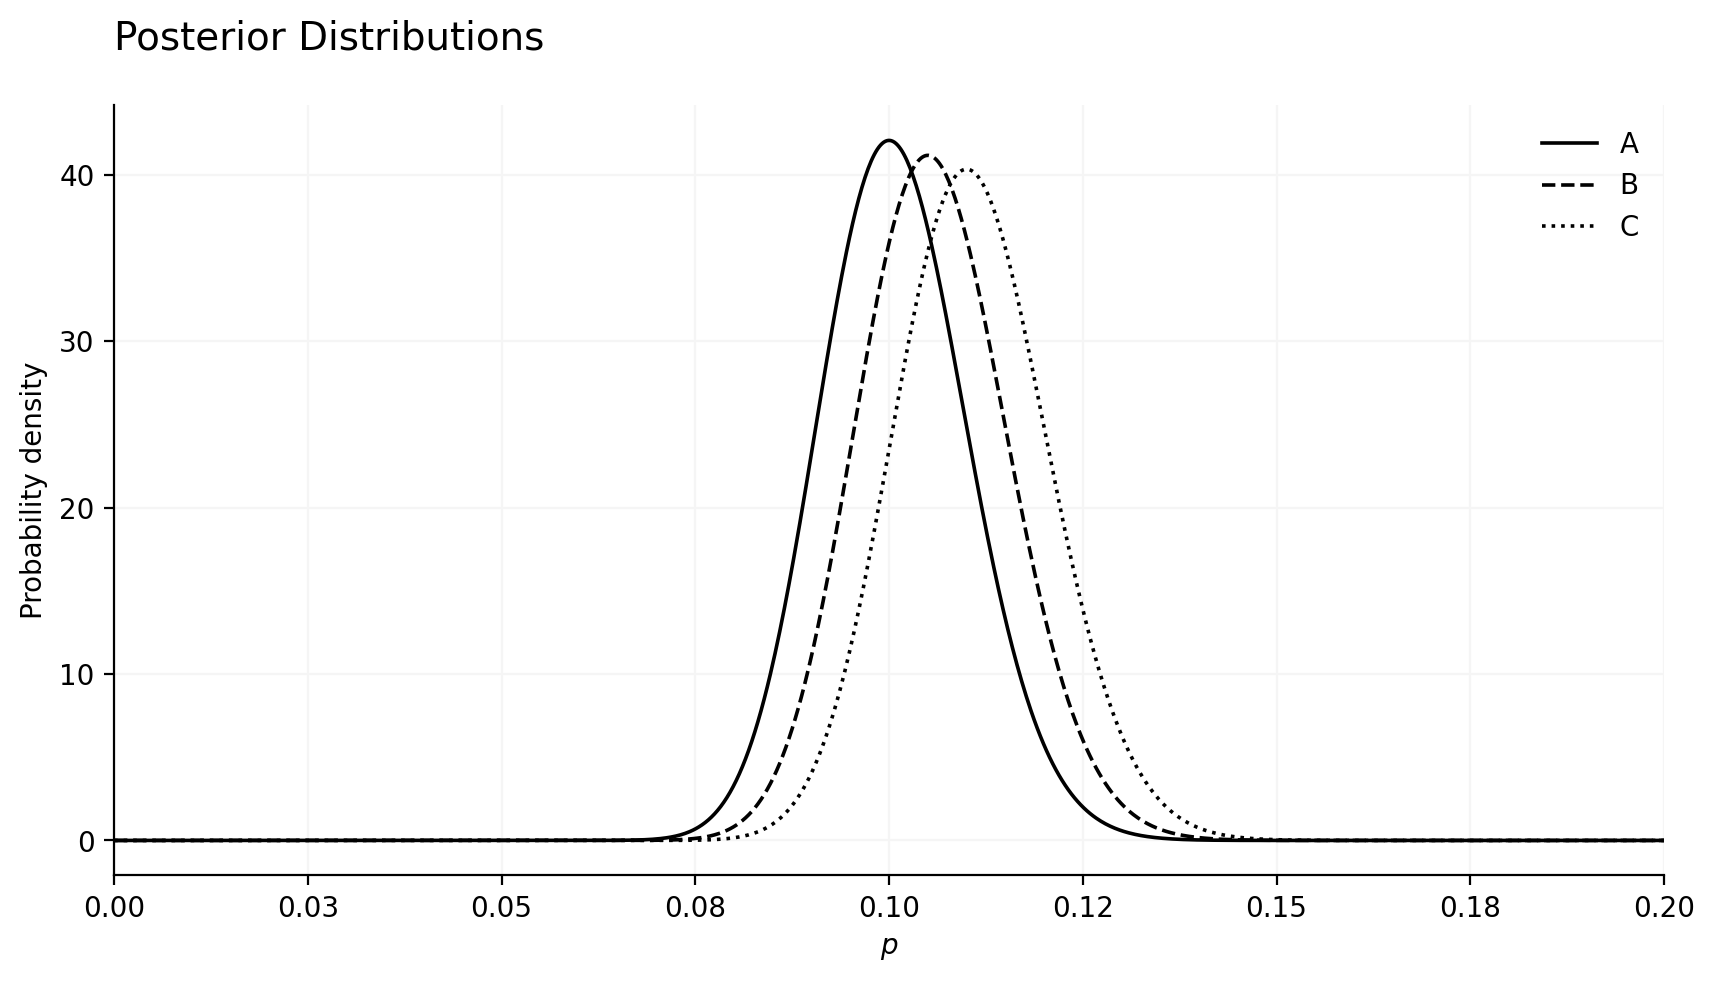

P Best:
P(Best A) = P(A>B & A>C) = 0.14598
P(Best B) = P(B>A & B>C) = 0.30072
P(Best C) = P(C>A & C>B) = 0.5533


In [2]:
def posterior_dist_binom(ns, ntotal, a_prior=1, b_prior=1):
    a = a_prior + ns
    b = b_prior + ntotal - ns 
    return stats.beta(a=a, b=b)

N = 1000
sa = 100
sb = 105
sc = 110

p_dist_a = posterior_dist_binom(ns=sa, ntotal=N)
p_dist_b = posterior_dist_binom(ns=sb, ntotal=N)
p_dist_c = posterior_dist_binom(ns=sc, ntotal=N)

npost = 50000
samp_a = p_dist_a.rvs(size=npost)
samp_b = p_dist_b.rvs(size=npost)
samp_c = p_dist_c.rvs(size=npost)

p_a_best = np.sum((samp_a > samp_b) & (samp_a > samp_c)) / npost
p_b_best = np.sum((samp_b > samp_a) & (samp_b > samp_c)) / npost
p_c_best = np.sum((samp_c > samp_a) & (samp_c > samp_b)) / npost

xaxis_max = 0.2
x = np.linspace(0, xaxis_max, 1000)
plt.figure()
plt.plot(x, p_dist_a.pdf(x), color="black", label="A")
plt.plot(x, p_dist_b.pdf(x), color="black", linestyle="--", label="B")
plt.plot(x, p_dist_c.pdf(x), color="black", linestyle=":", label="C")
plt.title("Posterior Distributions")
plt.xlabel(r"$p$")
plt.ylabel("Probability density")
plt.xlim(0, xaxis_max)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.legend()
plt.show()

print(f"P Best:")
print(f"P(Best A) = P(A>B & A>C) = {p_a_best}")
print(f"P(Best B) = P(B>A & B>C) = {p_b_best}")
print(f"P(Best C) = P(C>A & C>B) = {p_c_best}")

The number of correctly identified variants across a series of experiments is as follows.
Group A has a fixed conversion rate of `p=0.1`, while groups B and C have conversion rates randomly selected within $\pm 5\%$ of `p`. Data are generated incrementally in each group with a step size of `n_samp_step`.
At each step, posterior distributions are updated, and the probability of having the highest conversion rate — $P(\text{Best }A)$, etc. — is calculated for each variant. The experiment stops when either the probability of the highest conversion in any group reaches `prob_stop = 0.95`, or when the maximum number of samples `n_samp_max` is reached. A total of `nexps` experiments are performed, and the proportion of correctly identified groups is measured. In this case, with `nexps = 200`, the correct group was identified 188 times. The resulting proportion, 0.94, is close to the expected value of `prob_stop = 0.95`.

In [3]:
def p_best(*args, n_post_samp=50_000):
    samp = [d.rvs(size=n_post_samp) for d in args]
    best_group = np.argmax(np.vstack(samp), axis=0)
    u = np.unique(best_group, return_counts=True)
    p_best = np.zeros(len(args))
    for i, c in zip(u[0], u[1]):
        p_best[i] = c
    p_best = p_best / n_post_samp
    return p_best

cmp = pd.DataFrame(columns=['A', 'B', 'C', 'best_exact', 
                            'exp_samp_size', 'A_exp', 'B_exp', 'C_exp', 
                            'best_exp', 'p_best'])

p = 0.1
nexps = 200
cmp['A'] = [p] * nexps
cmp['B'] = p * (1 + stats.uniform.rvs(loc=-0.05, scale=0.1, size=nexps))
cmp['C'] = p * (1 + stats.uniform.rvs(loc=-0.05, scale=0.1, size=nexps))
cmp['best_exact'] = cmp.apply(lambda r: 'A' if r['A'] > r['B'] and r['A'] > r['C'] else 'B' if r['B'] > r['A'] and r['B'] > r['C'] else 'C', axis=1)

n_samp_max = 30_000_000
n_samp_step = 10_000
prob_stop = 0.95

for i in range(nexps):
    pA = cmp.at[i, 'A']
    pB = cmp.at[i, 'B']
    pC = cmp.at[i, 'C']
    exact_dist_A = stats.bernoulli(p=pA)
    exact_dist_B = stats.bernoulli(p=pB)
    exact_dist_C = stats.bernoulli(p=pC)
    n_samp_total = 0
    ns_A = 0
    ns_B = 0
    ns_C = 0
    while n_samp_total < n_samp_max:
        dA = exact_dist_A.rvs(n_samp_step)
        dB = exact_dist_B.rvs(n_samp_step)
        dC = exact_dist_C.rvs(n_samp_step)
        n_samp_total += n_samp_step
        ns_A = ns_A + np.sum(dA)
        ns_B = ns_B + np.sum(dB)
        ns_C = ns_C + np.sum(dC)
        post_dist_A = posterior_dist_binom(ns=ns_A, ntotal=n_samp_total)
        post_dist_B = posterior_dist_binom(ns=ns_B, ntotal=n_samp_total)
        post_dist_C = posterior_dist_binom(ns=ns_C, ntotal=n_samp_total)
        p_best_A, p_best_B, p_best_C = p_best(post_dist_A, post_dist_B, post_dist_C)
        best_gr = 'A' if p_best_A >= prob_stop else 'B' if  p_best_B >= prob_stop else 'C' if p_best_C >= prob_stop else None
        if best_gr:
            cmp.at[i, 'A_exp'] = post_dist_A.mean()
            cmp.at[i, 'B_exp'] = post_dist_B.mean()
            cmp.at[i, 'C_exp'] = post_dist_C.mean()
            cmp.at[i, 'exp_samp_size'] = n_samp_total
            cmp.at[i, 'best_exp'] = best_gr
            cmp.at[i, 'p_best'] = max(p_best_A, p_best_B, p_best_C)
            break
    print(f'done {i}: nsamp {n_samp_total}, best_gr {best_gr}, P_best {max(p_best_A, p_best_B, p_best_C)}')

cmp['correct'] = cmp['best_exact'] == cmp['best_exp']
display(cmp.head(50))
cor_guess = np.sum(cmp['correct'])
print(f"Nexp: {nexps}, Correct Guesses: {cor_guess}, Accuracy: {cor_guess / nexps}")

done 0: nsamp 10000, best_gr B, P_best 0.98148
done 1: nsamp 6660000, best_gr B, P_best 0.95386
done 2: nsamp 100000, best_gr B, P_best 0.95934
done 3: nsamp 200000, best_gr A, P_best 0.98418
done 4: nsamp 190000, best_gr C, P_best 0.96984
done 5: nsamp 50000, best_gr B, P_best 0.95744
done 6: nsamp 80000, best_gr C, P_best 0.95
done 7: nsamp 460000, best_gr A, P_best 0.96326
done 8: nsamp 270000, best_gr C, P_best 0.9511
done 9: nsamp 90000, best_gr B, P_best 0.9638
done 10: nsamp 80000, best_gr C, P_best 0.97802
done 11: nsamp 30000, best_gr C, P_best 0.98924
done 12: nsamp 10000, best_gr C, P_best 0.99222
done 13: nsamp 10000, best_gr B, P_best 0.99528
done 14: nsamp 90000, best_gr B, P_best 0.97714
done 15: nsamp 80000, best_gr C, P_best 0.96846
done 16: nsamp 50000, best_gr B, P_best 0.95812
done 17: nsamp 70000, best_gr C, P_best 0.992
done 18: nsamp 710000, best_gr A, P_best 0.95796
done 19: nsamp 70000, best_gr B, P_best 0.9621
done 20: nsamp 70000, best_gr C, P_best 0.97144
do

,A,B,C,best_exact,exp_samp_size,A_exp,B_exp,C_exp,best_exp,p_best,correct
0,0.1,0.104364,0.096730,B,10000,0.10088,0.109978,0.094281,B,0.98148,True
1,0.1,0.100215,0.097550,B,6660000,0.100053,0.10033,0.09742,B,0.95386,True
2,0.1,0.101895,0.098018,B,100000,0.099028,0.101668,0.098928,B,0.95934,True
3,0.1,0.095718,0.096861,A,200000,0.098819,0.096039,0.096794,A,0.98418,True
4,0.1,0.099416,0.101859,C,190000,0.099383,0.099136,0.101373,C,0.96984,True
5,0.1,0.104006,0.098028,B,50000,0.099536,0.102916,0.097956,B,0.95744,True
6,0.1,0.101920,0.103963,C,80000,0.100172,0.101635,0.104172,C,0.95,True
7,0.1,0.099005,0.098880,A,460000,0.100389,0.099265,0.098332,A,0.96326,True
8,0.1,0.098854,0.102039,C,270000,0.099518,0.098244,0.100884,C,0.9511,True
9,0.1,0.104319,0.095381,B,90000,0.101387,0.103942,0.094309,B,0.9638,True


Nexp: 200, Correct Guesses: 188, Accuracy: 0.94


A Bayesian approach was applied to an A/B test involving three groups.
The best-performing group was identified by comparing their posterior distributions.
This method can also be used for other metrics and a larger number of variants.

**References**:
  
[BetaDist] - [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution), *Wikipedia.*     
[Bonf] - [Bonferroni Correction](https://en.wikipedia.org/wiki/Bonferroni_correction), *Wikipedia.*  
[ConjPrior] - [Conjugate Prior](https://en.wikipedia.org/wiki/Conjugate_prior), *Wikipedia.*   
[FWER] - [Family-wise Error Rate](https://en.wikipedia.org/wiki/Family-wise_error_rate), *Wikipedia.*   
[MultipleComp] - [Multiple Comparisons Problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem), *Wikipedia.*  
[SciPyBeta] - [scipy.stats.beta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html), *SciPy Reference.* 